In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# **PART 1.0 - DATA PREPROCESSING**

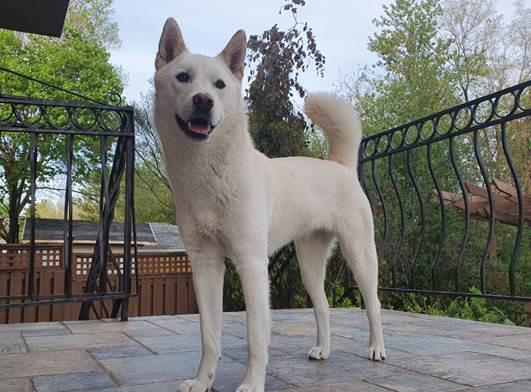

In [2]:
with Image.open('9374.jpg') as im:
  display(im) #showing a sample dog image from the dataset

In [ ]:
path = 'CATS_DOGS\\' #path right before the train test split
img_names =[] #creating an empty list to take in all the image names

for folder,subfolders,filenames in os.walk(path):
  for img in filenames:
    img_names.append(folder+'/'+img)

print('There are',len(img_names),'images')
print(img_names[-1])

In [4]:
img_sizes = []
rejected = []

for item in img_names:
  try:
    with Image.open(item) as img:
      img_sizes.append(img.size)

  except:
    rejected.append(item)

print(len(img_sizes))
print(len(rejected))  

49988
0


In [5]:
df = pd.DataFrame(img_sizes)
df.head() #column 0 is width, column 1 is height of the image size

,0,1
0,500,375
1,300,281
2,489,500
3,403,500
4,150,150


In [6]:
df[0].describe() #so width is from 42 to 500 pixels, with a mean of 404, so not too many small images. This will help us decide an input size for our CNN

count    49988.000000
mean       404.653277
std        111.328083
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max       4032.000000
Name: 0, dtype: float64

In [7]:
df[1].describe() #so height is from 33 to 500, with a mean of 361, so not too many small images. This will help us decide an input size for our CNN

count    49988.000000
mean       361.150156
std         98.385575
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max       3024.000000
Name: 1, dtype: float64

# 1.1 Transforming for Training

In [8]:
#Transforming our data into a tensor, along with a uniform size, implementing random flips/rotations, and normalizing to actually feed into our training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees = 117),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),     
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])          
])

In [9]:
#For the next set, we don't need to do the random flips or rotation, since we're just testing and not training
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),     
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])          
])

In [10]:
train_data = datasets.ImageFolder(root = 'CATS_DOGS\\train', transform = train_transform) #pointing the path to the training data and applying the transform made above
test_data = datasets.ImageFolder(root = 'CATS_DOGS\\test', transform = test_transform) #pointing the path to the training data and applying the transform made above

train_loader = DataLoader(train_data, batch_size=10, shuffle = True) #so now we're loading in the data from the CIFAR training Dataset, and we only load it in in batches of 10 rows at a time out of the 60000 images, with the rows being shuffled (random) 
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

class_names = train_data.classes
print(class_names) #Notice the two classes are CAT and DOG, based on the folder titles

['CAT', 'DOG']


In [11]:
print(len(train_data))
print(len(test_data))

18743
6251


In [12]:
for images,labels in train_loader:
  # this for loop will happen 18743 times
  #so for the sake of an example, say we break out of this for loop after the first batch
  break

print(labels)
print(labels.shape)
print(images.shape) #notice how it's a 4D tensor with the first element being batch size = 10, colour channels = 3, and 224x224 is the size of the image

tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])
torch.Size([10])
torch.Size([10, 3, 224, 224])


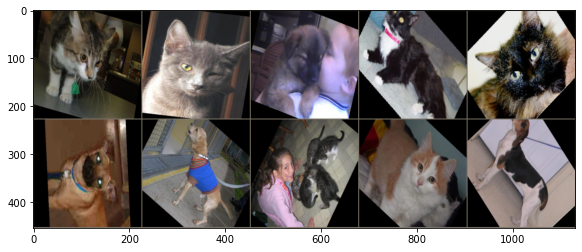

In [13]:
im = make_grid(tensor = images, nrow = 5)

#Can reverse the normalization by dividing the means by the standard deviation, as well as getting the 1/standard deviation
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# **PART 2 - PRETRAINED ALEXNET MODEL**

In [54]:
AlexNetModel = models.alexnet(pretrained=True,) #notice how there are a bunch of pretrained models we can select from thanks to from torchvision import models
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
#Here we're going to freeze the pre-trained weights and biases 
for param in AlexNetModel.parameters():
  param.requires_grad = False #so we won't let it back propagate, so the weights and biases won't change

In [17]:
#So AlexNet has 1000 classification outputs, but we only want 2 (For cat and dog)
#If you look at the Architecture above, the architecture is separated by the Sequential object. Essentially, sequential sets up a sequence of neural network layers where each level can include Linear functions, activation functions, pooling layers, convolutional layers, drop out layers, etc. Using sequential combines the layers from a layers list so that it can be ordered properly as a NN, and it is useful for quickly adding in layers and activation functions
#So in our case, we want to grab the Classifier sequential object, such that we can change the outputs from 1000 to 2
AlexNetModel.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(9216,4096),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(4096,1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 2),
                                        nn.LogSoftmax(dim=1)) #Here we modified the classifier object to now follow these layers instead. We had to keep the same input, but was able to change the hidden layers and the output

AlexNetModel #notice the new layers in classifier object

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
for param in AlexNetModel.parameters():
  print(param.numel()) #notice the last value is 2 which makes sense. The last 6 are basically the number of parameters for the classifier object, everything above is for the other 2 objects

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
4194304
1024
2048
2


In [19]:
criterion = nn.CrossEntropyLoss() #so our loss measurement will be based off CrossEntropyLoss since this is a mutually exclusive answer (only 1 target can be correct)

optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(), lr = 0.001) #only optimizing the AlexNetModel.classifier object because this is the one where we'll need new weights and biases
AlexNetModel.classifier.parameters #can see the parameters are just the fully connected layers and we are optimizing them

<bound method Module.parameters of Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)>

In [20]:
import time #Gonna keep track of how long it takes to train our model

start_time = time.time()

epochs = 41

#Trackers for visualization
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#This for loop trains our NN
for i in range(epochs):
  #Forward propagation through our ANN using training data
  train_corr = 0
  test_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    #b = batches and enumerate just counts what batch number we're on with b, and basically using tuple unpacking to get the X_train and y_train
    b += 1
    y_pred = AlexNetModel.forward(x = X_train) #recall in ANN we had to flatten the images in this step, but now that we're using CNN, it's already done for us in the class CNN

    #Calculating loss/error
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data,1)[1] #so recall we have 10 output neurons providing a probability on what they think the answer to the image is. Here we are grabbing the highest probabilty along the column axis = 1, and indexing it to get the actual predicted value
    batch_corr = (predicted == y_train).sum() #summing how many we got correct
    train_corr += batch_corr #adding to the train_corr 

    #Backpropagation
    optimizer.zero_grad() #resetting the gradient on the optimizer so it doesn't accumulate
    loss.backward() #doing backpropagation off the loss function
    optimizer.step() #using the optimizer for the back propagation

    if b%400 == 0:
      acc = train_corr.item()*10/(100*b)
      print(f'Epoch {i}    batch{b}    loss:{loss.item()}    accuracy: {acc} ')
    
  train_losses.append(loss)
  train_correct.append(train_corr)

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = AlexNetModel.forward(x = X_test) #recall in ANN we had to flatten the images in this step, but now that we're using CNN, it's already done for us in the class CNN
      predicted = torch.max(y_val.data,1)[1] #so recall we have 10 output neurons providing a probability on what they think the answer to the image is. Here we are grabbing the highest probabilty along the column axis = 1, and indexing it to get the actual predicted value
      test_corr += (predicted == y_test).sum() #summing how many we got correct

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)

print(f'Training took {(time.time() - start_time)/60} minutes')

Epoch 0    batch400    loss:0.422417551279068    accuracy: 0.821 
Epoch 0    batch800    loss:0.35815611481666565    accuracy: 0.8345 
Epoch 0    batch1200    loss:0.2612125277519226    accuracy: 0.8419166666666666 
Epoch 0    batch1600    loss:0.17845949530601501    accuracy: 0.8491875 
Epoch 1    batch400    loss:0.07234210520982742    accuracy: 0.88225 
Epoch 1    batch800    loss:0.5466066002845764    accuracy: 0.884875 
Epoch 1    batch1200    loss:0.06279551237821579    accuracy: 0.88125 
Epoch 1    batch1600    loss:0.18964038789272308    accuracy: 0.8800625 
Epoch 2    batch400    loss:0.20684805512428284    accuracy: 0.876 
Epoch 2    batch800    loss:0.6532144546508789    accuracy: 0.88225 
Epoch 2    batch1200    loss:0.19959452748298645    accuracy: 0.8851666666666667 
Epoch 2    batch1600    loss:0.26661795377731323    accuracy: 0.886875 
Epoch 3    batch400    loss:0.2889004945755005    accuracy: 0.8805 
Epoch 3    batch800    loss:0.8191830515861511    accuracy: 0.885625

In [30]:
torch.save(AlexNetModel.state_dict(), 'CatDogCNN_AlexNet.pt')

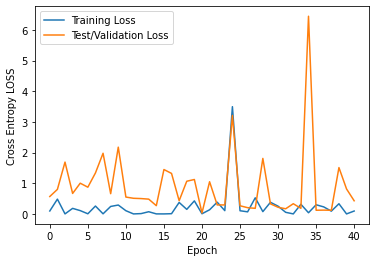

In [48]:
#Plotting our error
plt.plot(train_losses,label = 'Training Loss')
plt.plot(test_losses, label = 'Test/Validation Loss')
plt.ylabel('Cross Entropy LOSS')
plt.xlabel('Epoch') 
plt.legend()

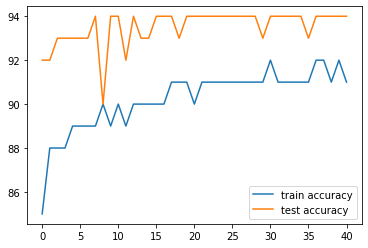

In [49]:
test_acc = [t//62.6 for t in test_correct] #62.5 = 625 batches per epoch / 10 batch size
train_acc = [t//187.5 for t in train_correct] #187.5 = 1875 batches per epoch / 10 batch size

plt.plot(train_acc, label = 'train accuracy')
plt.plot(test_acc, label = 'test accuracy')
plt.legend()

In [50]:
# NEW UNSEEN DATA

test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

#This just turns off the backpropagation, so we can use the model for evaluation rather than training. This helps reduce memory usage and computation speed
with torch.no_grad():
  correct = 0

  for X_test, y_test in test_load_all:
    y_val = AlexNetModel.forward(x = X_test) 
    predicted = torch.max(y_val, 1)[1] #so recall we have 2 output neurons providing a probability on what they think the answer to the image is. Here we are grabbing the highest probabilty along the column axis = 1, and indexing it to get the actual predicted value
    correct += (predicted == y_test).sum() #summing how many we got correct

print('Total accuracy on Test Set = ', correct.item()/len(test_data)*100, '%')

Total accuracy on Test Set =  95.5047192449208 %


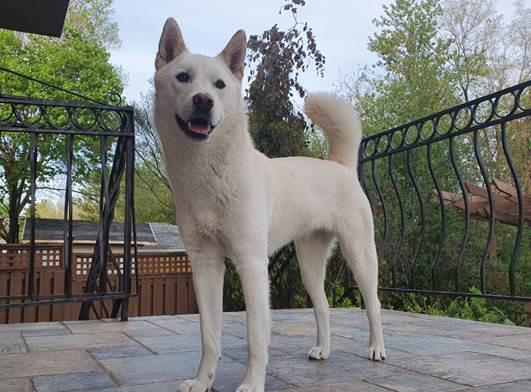

(531, 392)
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


In [92]:
dog = Image.open('9374.jpg')

display(dog)
print(dog.size) #so width of 500 and height of 428


#So we need to transform our .jpg files into a tensor object if we want to feed it into PyTorch
#.Compose allows us to do multiple transformations, including converting into a tensor
transform = transforms.Compose([  
    #Now doing all the transforms mentioned above to actually feed into our training data
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),     
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])          
])

im = transform(dog)
print(type(im)) #now we're transformed into a PyTorch tensor
print(im.shape) #the size now has index 0 equal to 3, for 3 colour channels in RGB

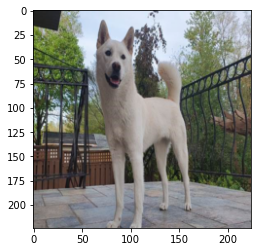

In [27]:
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [28]:
test_data[image_index][0].shape

torch.Size([3, 224, 224])

In [51]:
AlexNetModel.eval()
with torch.no_grad():
  new_pred = AlexNetModel(im.view(1,3,224,224)).argmax()
print('AlexNetModel thinks Dooboo (my dog) is a', class_names[new_pred.item()])

AlexNetModel thinks Dooboo (my dog) is a DOG


In [52]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[2924,   79],
       [ 202, 3046]], dtype=int64)

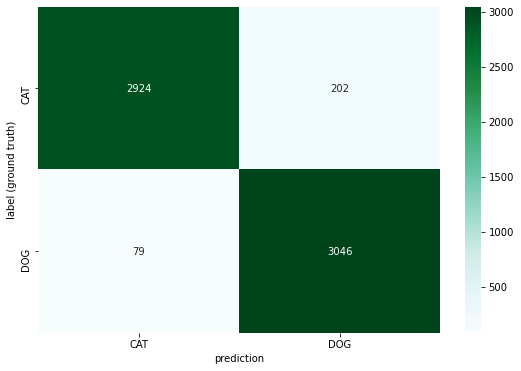

In [53]:
# Create a loader for the entire the test set
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();